# **[Verifying the Assumptions of Linear Regression in Python and R](https://towardsdatascience.com/verifying-the-assumptions-of-linear-regression-in-python-and-r-f4cd2907d4c0)**

An article of **Eryk Lewinson**. Jun 3, 2019.

With extra references from:
- [**Zach. Jul 21, 20220. How To perform a Durbin-Watson Test in Python**](https://www.statology.org/durbin-watson-test-python/)

---

In [211]:
# Data manipulation
import pandas as pd
import numpy as np

# Data Viz
import seaborn as sns
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 10.0)
import matplotlib.pyplot as plt

# Data modeling
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats.api as sms
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import pearsonr
from scipy import stats

# Miscelanous
import os

## **1. Data**

In [ ]:
# Import the data
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
boston = pd.read_csv('data/housing.xls', header=None, delimiter=r'\s+', names=column_names)

# Show the head
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [105]:
# Define the X and Y set for training
X = boston.drop(['CHAS', 'MEDV'], axis=1)
y = boston['MEDV']

## **2. Running Linear Regression**

In [107]:
# Compute a basic linear regression with Scklearn
lin_reg = LinearRegression()
lin_reg.fit(X, y)

# Print attributes
print(f'> Coefficients: {lin_reg.coef_}')
print(f'> Intercept: {lin_reg.intercept_}')
print(f'> R2 score: {lin_reg.score(X, y)}')

> Coefficients: [-1.13139078e-01  4.70524578e-02  4.03114536e-02 -1.73669994e+01
  3.85049169e+00  2.78375651e-03 -1.48537390e+00  3.28311011e-01
 -1.37558288e-02 -9.90958031e-01  9.74145094e-03 -5.34157620e-01]
> Intercept: 36.891959796932895
> R2 score: 0.7355165089722999


In [116]:
# Compute a basic linear regression with Statsmodels

X_constant = sm.add_constant(X) # Adds a new column with ones for the intercept computation
lin_reg = sm.OLS(y, X_constant).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     114.3
Date:                Sun, 11 Dec 2022   Prob (F-statistic):          7.30e-134
Time:                        12:07:27   Log-Likelihood:                -1503.8
No. Observations:                 506   AIC:                             3034.
Df Residuals:                     493   BIC:                             3088.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.8920      5.147      7.168      0.000      26.780      47.004
CRIM          -0.1131      0.033     -3.417      0.001      -0.178      -0.048
ZN             0.0471      0.014      3.398      0.001       0.020       0.074
INDUS          0.0403      0.062      0.653      0.514      -0.081       0.162
NOX          -17.3670      3.851     -4.509      0.000     -24.934      -9.800
RM             3.8505      0.421      9.137      0.000       3.023       4.678
AGE            0.0028      0.013      0.209      0.834      -0.023       0.029
DIS           -1.4854      0.201     -7.383      0.000      -1.881      -1.090
RAD            0.3283      0.067      4.934      0.000       0.198       0.459
TAX           -0.0138      0.004     -3.653      0.000      -0.021      -0.006
PTRATIO       -0.9910      0.131     -7.542      0.000      -1.249      -0.733
B              0.0097      0.003      3.600      0.000       0.004       0.015
LSTAT         -0.5342      0.051    -10.459      0.000      -0.635      -0.434
==============================================================================
Omnibus:                      190.856   Durbin-Watson:                   1.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              898.352
Skew:                           1.619   Prob(JB):                    8.42e-196
Kurtosis:                       8.668   Cond. No.                     1.51e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## **Gauss-Markov Theorem**

According to the **[Gauss-Markov theorem](https://en.wikipedia.org/wiki/Gauss%E2%80%93Markov_theorem)**, in a linear regression model the ordinary least squares **(OLS)** estimator gives the **B**est **L**inear **U**nbiased **E**stimator **(BLUE)** of the cofficients, provided that:

- The expectation of errors **(residuals)** is **0**
- The **errors** are **uncorrelated**
- The **errors** have **equal variance** - **homocedasticity** of errors

For the estimator to be **BLUE**, the residuals do not need to follow normal (Gaussian) distribution, nor do they need to be **independent and identically distributed**.

### **Linearity test**

To detect nonlinearity one can inspect plots of **observed vs. predicted values** or **residuals vs. predicted values**. The desired output is that, for:

- **observed vs. predicted values**: Points are symmetrically distributed around a **diagonal** line.
- **residuals vs. predicted values**: Points are symmetrically distrubuted around a **horizontal** line.

In [143]:
def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model. It plots observed vs. predictes value and residuals vs. predicted
    values.
    
    Args.
    * model - fitte OLS model from statsmodels
    * y - observed values
    '''

    # Create a dictionary for the regplot parameters
    regplot_kws = dict(lowess=True, line_kws={'color':'red', 'ls':'--'})

    fitted_vals = model.predict() # Compute predictions with the fit values
    resids = model.resid # Call the residuals from the prediction

    # Generate a figure and axs for plotting
    fig, ax = plt.subplots(1, 2)

    # Observed vs. Predicted
    # ---
    sns.regplot(x=fitted_vals, y=y, ax=ax[0], **regplot_kws)
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    # Residuals vs. Predicted Values
    # ---
    sns.regplot(x=fitted_vals, y=resids, ax=ax[1], **regplot_kws)
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')

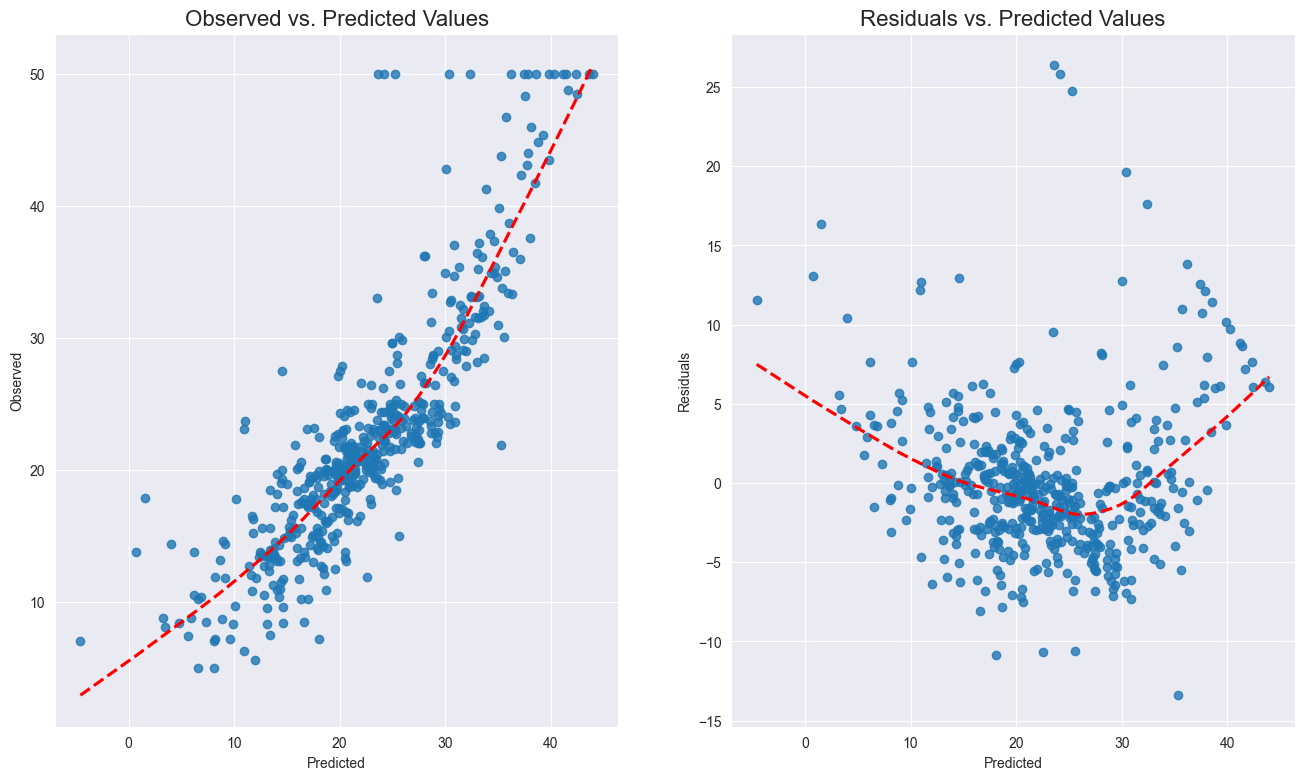

In [144]:
linearity_test(lin_reg, y)

Observing a **bowed** pattern indicates that the model makes systematic errors whenever it is making unusually large or small predictions.

When the model contains many features, nonlinearity can also be revaled by systematic patterns in plots of the residuals vs. individual features.

The inspection of the plots shows that the **linearity assumption** is not satisfied.

### **Expectation (mean) of residuals is zero**

In [145]:
# Check it via statsmodels
lin_reg.resid.mean()

-3.027529917586514e-14

We can assume that **the expectation of residuals** is 0.

### **No (perfect) multiconlinearity**

The features should be linearly independent... We should not be able to use a **linear model** to accurately **predict** one feature using another one.

One scenario to watch out for is the **dummy variable trap**, when we use dummy variables to encode a categorical feature and do not omit the baseline level from the model. This results in a **perfect correlation between the dummy and the constant term.**

**Multicolinearity** can be present in the model, as long as it is not 'perfect'.

We can detect **multicolinearity** using the [**Variance Inflation Factor (VIF)**](https://en.wikipedia.org/wiki/Variance_inflation_factor). The interpretation of **VIFF** is as follows:

The *square root* of a given variables **VIF** shows how much larger the standard error is, compared with what it would be if that predictor were uncorrelated with other features in the model. **If no features are correlated, then all values for VIF will be 1**.

In [150]:
# Compute the VIF with statsmodels
vif = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]

# Show the results in a tabular form
pd.DataFrame({'vif': vif[1:]}, index=X.columns).T

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
vif,1.787705,2.298257,3.949246,4.388775,1.931865,3.092832,3.954961,7.397844,8.876233,1.783302,1.344971,2.931101


To deal with **multicolinearity**, we should iteratively remove features with high values of **VIF**. A rule of thumb for removal could be **VIF** larger than 10 (5 is also common). Another possible solution is to use **PCA** to reduce features to a smaller set of uncorrelated components.

Tip: we can also look at the **correlation matrix** of features to identify dependencies between them.

<AxesSubplot: >

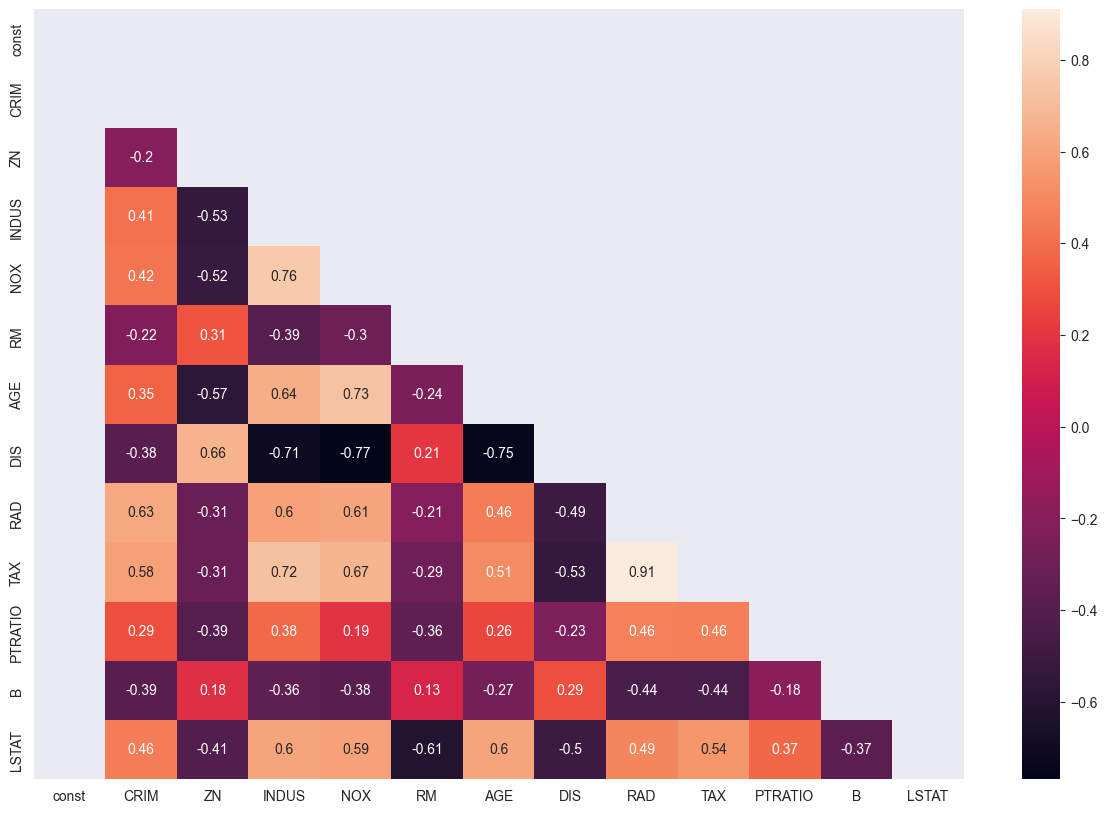

In [156]:
# Compute the correlation between the features
X_corr = X_constant.corr()

# Create a mask for getting only the bottom values of the corr
mask = np.triu(np.ones_like(X_corr, dtype=bool))

sns.heatmap(X_corr, mask=mask, annot=True)

### **Homocedasticity (equal variance) of residuals**

When residuals do not have constance variance (they exhibit **heterocedasticity**), its is difficult to determine the true **standard deviation of the forecast errors**, usually resulting in confidence intervals that are too wide/narrow.

To investiage if the **residuals are homocedastic**, we can look at a plot of residuals (or standarized residuals) vs. predicted (fitted values). What should alarm us is the case when the **residuals grow either as a function of predicted value of time** (in case of time series).

We can also use two statistical tests: **Breusch-Pagan** and **Goldfeld-Quandt**. In both of them, the **null hypothesis assumes homocedasticity** and a *p-value* below a threshold (like 0.05) indicates that **we should reject the null** in favor of **heterocedasticity**.

In [167]:
def homocedasticity_test(model):
    '''
    Function for testing the homocedasticity of residuals in a linear regression model.
    It plots residuals and standarized residuals vs. fitted values and runs Breusch-Paga and Goldfeld-Quandt tests.

    Args:
    * model - fitted OLS model from statsmodels.    
    '''
    # Create a dictionary for the regplot parameters
    regplot_kws = dict(lowess=True, line_kws={'color':'red', 'ls':'--'})

    fitted_vals = model.predict() # Predic with fit values
    resids = model.resid # Call the resids
    resids_standarized = model.get_influence().resid_studentized_internal # Standarize the residuals

    # Generate a figure and subplots for plotting
    fig, ax = plt.subplots(1, 2)

    # Residuals vs. fitted
    sns.regplot(x=fitted_vals, y=resids, ax=ax[0], **regplot_kws)
    ax[0].set(title='Residuals vs. Fitted', xlabel='Fitted Values', ylabel='Residuals')

    # Fitted vs. Sqrt residuals
    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standarized)), ax=ax[1], **regplot_kws)
    ax[1].set(title='Scale-Location', xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

    # Compute the Breusch-Pagan test and save it in tabular form
    bp_test = pd.DataFrame(
        sms.het_breuschpagan(resids, model.model.exog),
        columns=['value'],
        index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
    )

    # Compute the Holdfeldquandt test and save it in a tabular form
    gq_test = pd.DataFrame(
        sms.het_goldfeldquandt(resids, model.model.exog)[:-1],
        columns=['value'],
        index=['F statistic', 'p-value']    
    )

    # Print the results
    print('\n Breusch-Pagan test ---')
    print(bp_test)

    print('\n Goldfeld-Quandt test ---')
    print(gq_test)

    print('\n Residual plots ---')


 Breusch-Pagan test ---
                                      value
Lagrange multiplier statistic  6.028613e+01
p-value                        2.001794e-08
f-value                        5.556828e+00
f p-value                      5.935449e-09

 Goldfeld-Quandt test
                    value
F statistic  2.620956e+00
p-value      1.251137e-13

 Residual plots ---


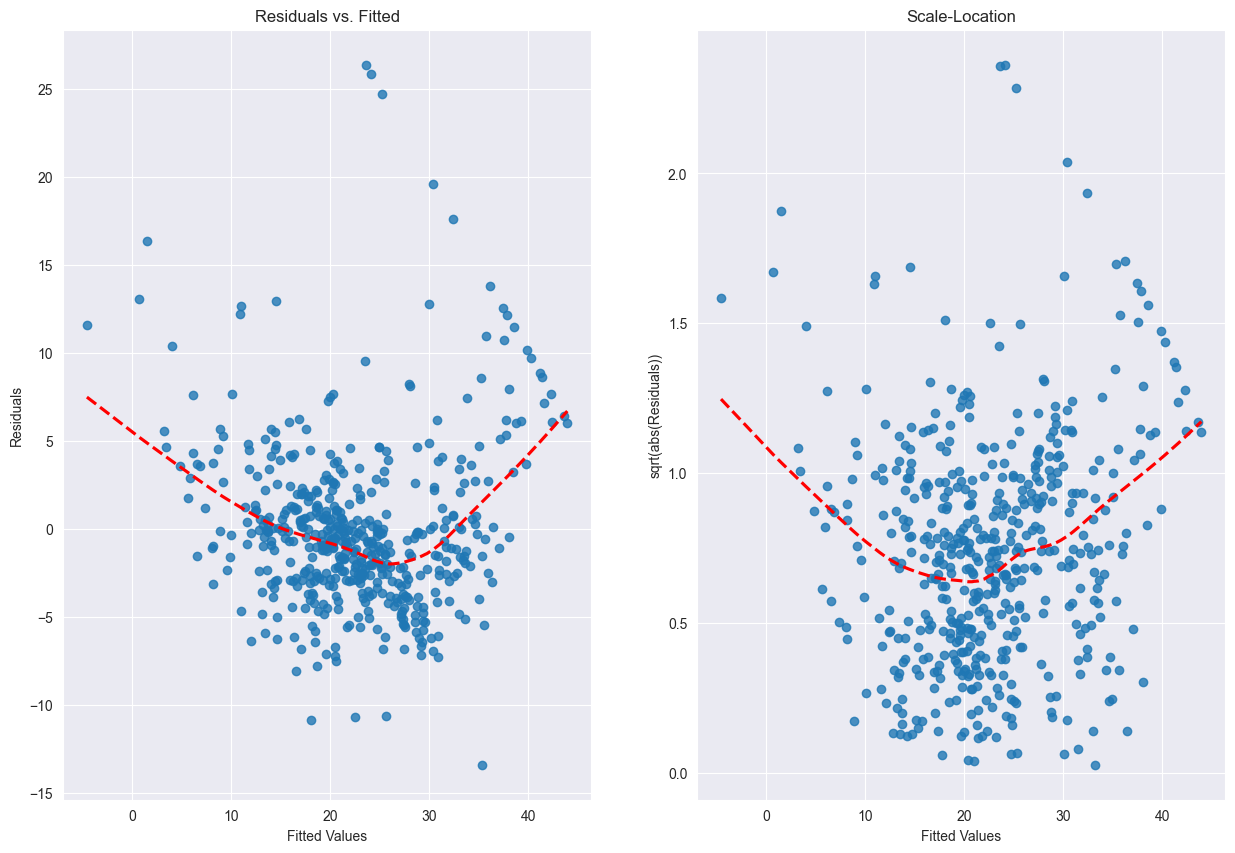

In [166]:
homocedasticity_test(lin_reg)

The results indicate that the assumption **is not satisfied** and we should **reject the hypothesis of homoscedasticity**.

Potential solutions:

- log transformation of the dependent variable
- in case of time series, deflating a series if it concerns monetary value
- using **ARCH (auto-regressive coonditional heterocedasticity)** models to model the error variance.

### **No autocorrelation of residuals**

This assumption is especially dangerous in **time-series** models, where serial correlation in the residuals implies that there is room for improvement in the model. 

**Extreme serial correlation** is often a sign of a badly misspecified model.

Another reason for **serial correlation** in the residuals could be a violation of the **linearity assumption** or due to **bias** that is explainable by **omitted variables** (interaction terms or dummy variables for identifiable conditions).

To investigate if **autocorrelation** is present, the author uses **ACF** (auto correlation function) plots and **Durbin-Watson** test.

- **ACF**: We want to see if the value of **ACF** is significant for any lag (in case of no time-series data, the row number is used). While calling the function, we indicate the **significance level** we are interested in and the critical area is plotted on the graph. **Significant correlations lie otuside of that area**.

- **Durbin-Watson test**: The test statistic provides a test for **significant residual autocorrelation at lag 1**. The DW statistic is approximately equal to $2(1-a)$ where $a$ is the lag 1 residual autocorrelation.
    - **$H_0$ (null hypothesis)**: There is **NO** correlation among the residuals.
    - **$H_A$ (alternative hypothesis)**: The residuals are **autocorrelated**.
    
    - The statistic will always be between 0 and 4, with the following interpretation:
        - A test statistic of **2** indicates no serial correlation.
        - The closer the test statistics is to **0** the more evidencence of positive serial correlation.
        - The closer the test statistics is to **4**, the more evidence of negative serial correlation.
        - As a rule of thumb, test statistic values between the range of **1.5** and **2.5** are considered normal. However, values outside this range could indicate that **autocorrelation** is a problem.

    - [**This is how you perform it in python**](https://www.statology.org/durbin-watson-test-python/)

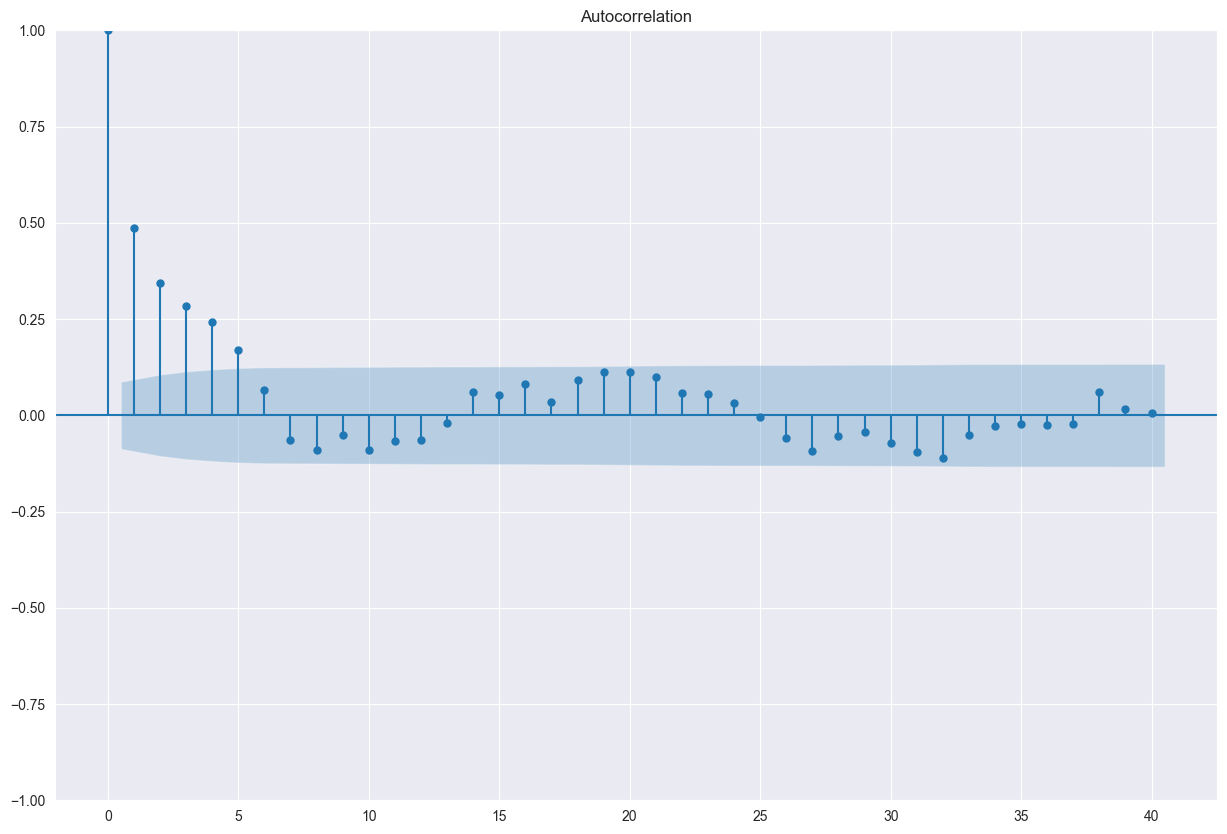

In [170]:
# Graph the autocorrelation function
acf = smt.graphics.plot_acf(lin_reg.resid, lags=40, alpha=0.05)

In [172]:
# Compute the Durbin-Watson test
print(f'\n Durbin Watson: {durbin_watson(lin_reg.resid)}')


 Durbin Watson: 1.015871729043387


According to the results, there is a true (residuals) **autocorrelation** greater than 0.

Potential solutions:

- In case of a minor positive autocorrelation, there might be some room for fine-tuning the model, for example, adding lags of the dependent/independent variables.
- Some **seasonal components** might not be captured by the model, account for them using dummy variables or seasonally adjust the variables.
- If DW < 1, it might indicate a possible problem in the model specification, consider **stationarizing time-series variables** by differencing, loggind and/or deflating (in case of monetary values).
- In case of a **significant negative correlation**, some of the variables might have been overdifferenced
- Use **Generalized Least Squares**
- Include a linear (trend) term in case of a consistent increasing/decreasing pattern in the residuals.

## **4. Other assumptions**

### **The features and residuals are uncorrelated**

To investigate this assumption, the author chcked the **Pearson correlation coefficient** between each feature and the residuals. Then report the *p-value* for testing the lack of correlation between the two considered series.

In [208]:
corr_tests = [dict(zip(['feature','statistic','p-value'], [feature] + list(pearsonr(X[feature], lin_reg.resid)))) for feature in X.columns]

# Show the results in a tabular form
pd.DataFrame(corr_tests)

,feature,statistic,p-value
0,CRIM,8.912142e-15,1.0
1,ZN,-5.636117e-15,1.0
2,INDUS,5.589821e-15,1.0
3,NOX,3.001939e-15,1.0
4,RM,-3.119900e-15,1.0
5,AGE,-7.394259e-17,1.0
6,DIS,-4.270456e-15,1.0
7,RAD,5.237998e-15,1.0
8,TAX,4.045375e-15,1.0
9,PTRATIO,3.656797e-15,1.0


### **The number of observations must be greater than the number of features**

This one is pretty straightforward. We can check the shape of our data by using `shape` method in Python or `dim` function in R. Also, a **rule of thumb** says that we should have more than **30 observations** in the dataset. This is taken from the **Central Limit Theorem**, which stats that adding IID random variable results in a normalized distribution when the sample size is greater than 30, even when the random variables are not **Gaussian** themselves.

### **There must be some variability in features**

This assumption satets that there must be some variance in the features, as a feature that has a constant value for all or the majority of observations might not be a good predictor. We can check this assumption by simply checking the variance of all features.

In [210]:
X.var()

CRIM          73.986578
ZN           543.936814
INDUS         47.064442
NOX            0.013428
RM             0.493671
AGE          792.358399
DIS            4.434015
RAD           75.816366
TAX        28404.759488
PTRATIO        4.686989
B           8334.752263
LSTAT         50.994760
dtype: float64

### **Normality of Residuals**

When this **assumption is violated**, it causes problems with calculating confidence intervals and various significance test for coefficients. When the error distribution significantly departs from Gaussian, confidence intervals may be too wide or too narrow.

Some of the potential reasons causing non-normal residuals:

- presence of a few large outliers in data
- there might be some other problems (violations) with the model assumptions
- another, better model specification might be better suited for this problem

To investigate this assumption, we can look at:

- **QQ plots** of the residuals (a detailed description can be found [**here**](https://towardsdatascience.com/explaining-probability-plots-9e5c5d304703))
- use statistical tests such as **Kolmogorov-Smirnov**, **Shapiro-Wilk**, **Jarque-Bera**, and the **Anderson-Darling** tests.

In [223]:
def normality_of_residuals_tests(model):
    '''
    Function for drawing the normal QQ-plot of the residuals and running 4 statistical tests to investigate the normality of residuals.

    Jarque-Bera: The null hypothesis for the test is that the data is normally distributed; The alternative hypothesis is that the data does not com from a normal distribution.

    Arg:
    * model - fitted OLS models from statsmodels
    '''  


    # Plot the QQ-Plot of residuals
    sm.ProbPlot(model.resid).qqplot(line='s')
    plt.title('Q-Q plot of Residuals')

    # Compute normality of residuals tests
    jb = stats.jarque_bera(model.resid)
    sw = stats.shapiro(model.resid)
    ad = stats.anderson(model.resid, dist='norm')
    ks = stats.kstest(model.resid, cdf='norm')

    # Print the results
    print(f'Jarque-Bera test ---- statistic: {jb[0]:.4f}, p-value: {jb[1]:.4f}')
    print(f'Shapiro-Wilk test ---- statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
    print(f'Kolmogorov-Smirnov test ---- statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
    print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')
    print('If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected.')

Jarque-Bera test ---- statistic: 898.3521, p-value: 0.0000
Shapiro-Wilk test ---- statistic: 0.8953, p-value: 0.0000
Kolmogorov-Smirnov test ---- statistic: 0.3283, p-value: 0.0000
Anderson-Darling test ---- statistic: 10.9109, 5% critical value: 0.7810
If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected.


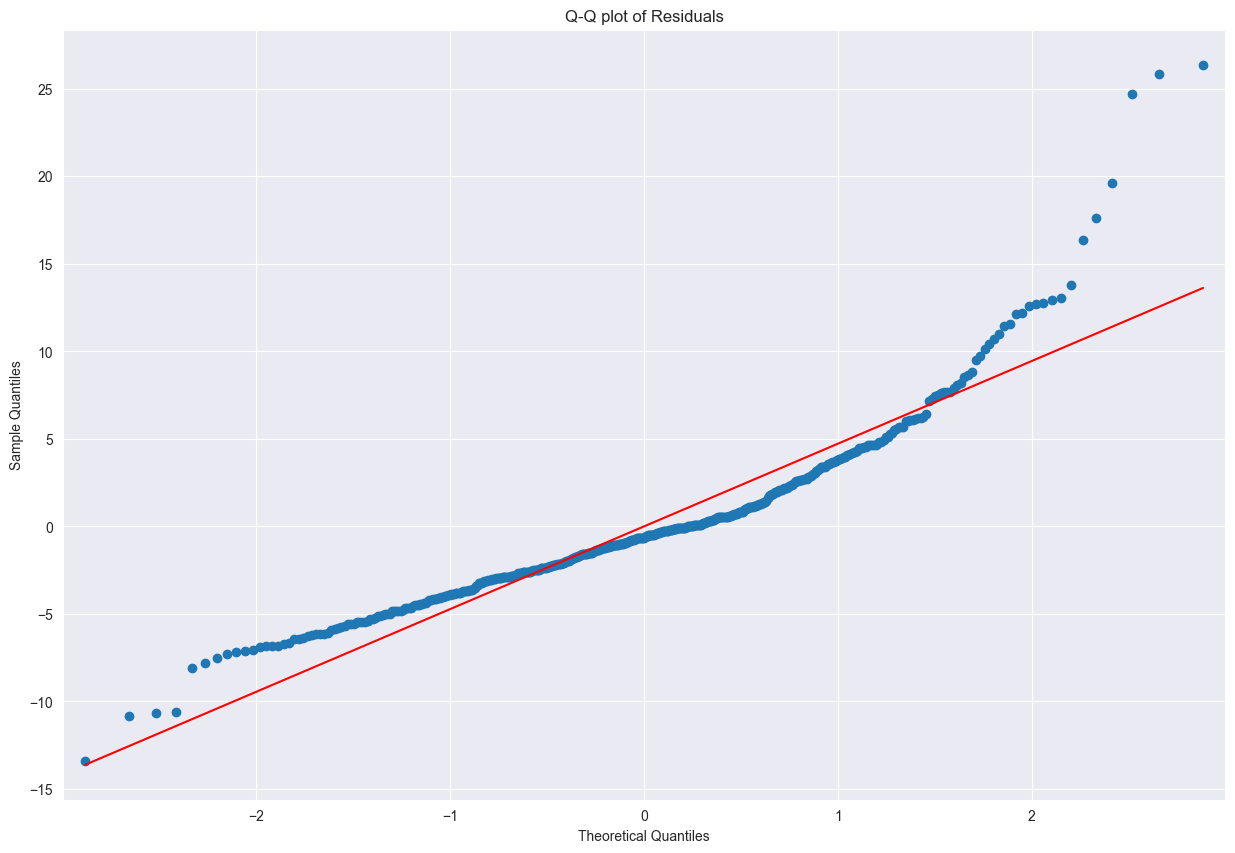

In [222]:
normality_of_residuals_tests(lin_reg)

From the results above, we can infer that the residuals do not follow **Gaussian distribution** from the shape of the QQ plot, as well as rejecting the null hypothesis in all statistical tests (of the distribution **DO NOT** follow a normal distribution).

**Potential solutions**

- nonlinear transformation of target variable or features
- remove/treat potential outliers
- it can happend that there are two or more subsets of the data having different statistical propoerties, in which case separated models might be considered

## **5. Bounis: Outliers**

This is not really an assumption, however, the existence of outliers in our data can lead to violations of some of the above mentioned assumptions.

A few potential approaches:

- Z-score
- Boxplot
- **Leverage**: a measure of how far away the feature values oa point are from the values of the differente observations. The **high-leverage** point is a point at extreme values of the variables, where the lack of nearby obesrvations makes the fitted regression model pass close to that particular point.
- **Cook's distance**: A measure of how deleting and observation impacts the regression model. **It makes sense to investigate points with high Cook's distances**.
- **Isolation Forest**: For more details see [**this article**](https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45)